In [1]:
import numpy as np
import pandas as pd

import pyopentd as pt


# 解析実行

In [2]:
# TDモデルの読み込み
dwg_path = "./td_model/sample.dwg"
td = pt.ThermalDesktop(dwg_path)

In [3]:
# ケースセットの一覧確認
casesets = td.get_casesets()
casesets.head()

,group_name,caseset_name,orbit_name,original_object
0,chamber,Case Set 0,,<pyopentd.main.Case object at 0x000001C268BD78B0>
1,chamber,steady,,<pyopentd.main.Case object at 0x000001C268BD7C40>
2,chamber,No rad,,<pyopentd.main.Case object at 0x000001C268BD7B50>
3,orbit,Case Set 2,sample_orbit,<pyopentd.main.Case object at 0x000001C268BD7C70>


In [4]:
# ケースセットの読み込み
# orbit.Case Set 2 以外は動かないので注意。
group_name = 'orbit'
caseset_name = 'Case Set 2'
case = td.get_caseset(caseset_name, group_name)

In [5]:
# 軌道情報の取得
orbit_name = case.get_orbit_name()
print(orbit_name)
df_orbit = td.get_orbit(orbit_name)
df_orbit.head()

sample_orbit


,Times,sun_x,sun_y,sun_z,planet_x,planet_y,planet_z,radius
0,0.000000,0.0,0.0,1.0,0.0,-1.066924e-13,-1.000000e+00,1.078393
1,473.081495,0.0,0.0,1.0,0.0,5.000000e-01,-8.660254e-01,1.078393
2,946.162989,0.0,0.0,1.0,0.0,8.660254e-01,-5.000000e-01,1.078393
3,1419.244484,0.0,0.0,1.0,0.0,1.000000e+00,-1.331770e-13,1.078393
4,1765.927780,0.0,0.0,1.0,0.0,9.272846e-01,3.743571e-01,1.078393


In [6]:
# 実行
case.run()

# 結果出力

In [7]:
sav_name = case.origin.SindaOptions.SaveFilename
print(sav_name)

case2.sav


In [8]:
sav_path = f'./td_model/{case.origin.UserDirectory}/{sav_name}'
sav_path

'./td_model/output/case2.sav'

In [9]:
savefile = pt.SaveFile(sav_path)

In [10]:
df_temp = savefile.get_all_temperature().drop('Times', axis=1)
df_heat = savefile.get_all_heatrate().drop('Times', axis=1)

In [11]:
def get_attitude(t_list, df):
    attitude_list = []
    for t in t_list:
        attitude = np.zeros(6)
        T_orbit = df.iloc[-1]['Times']
        dt = df.iloc[-1]['Times'] - df.iloc[-2]['Times']
        t = t % T_orbit
        t_bef_index = t // dt
        t_af_index = t_bef_index + 1
        
        attitude_bef = df.iloc[int(t_bef_index)].values
        attitude_af = df.iloc[int(t_af_index)].values
        
        rate = (t % dt) / dt
        attitude = (1-rate)*attitude_bef + rate*attitude_af
        
        attitude_list.append(attitude[1:])
    
    return pd.DataFrame(attitude_list, columns=df.columns[1:])

In [12]:
df_orbit_modify = get_attitude(savefile.times, df_orbit)
# df_orbit_modify
df_time = pd.DataFrame(savefile.times, columns=['Times'])
df_case = pd.DataFrame([f'{case.origin.GroupName}.{case.origin.Name}']*len(savefile.times), columns=['case'])

In [13]:
df = pd.concat([df_case, df_time, df_orbit_modify, df_temp, df_heat], axis=1)
df.to_csv('sample_output.csv', index=False)

In [14]:
df.head(10)

,case,Times,sun_x,sun_y,sun_z,planet_x,planet_y,planet_z,radius,CHAMBER.T1,...,PANEL_PZ.Q1,PANEL_PZ.Q2,PANEL_PZ.Q3,PANEL_PZ.Q4,PANEL_PZ.Q5,PANEL_PZ.Q6,PANEL_PZ.Q7,PANEL_PZ.Q8,PANEL_PZ.Q9,SPACE.Q1
0,orbit.Case Set 2,0.0,0.0,0.0,1.0,0.0,-1.066924e-13,-1.000000,1.078393,20.0,...,2.424313,2.444827,2.456372,2.473608,2.451783,2.467538,2.443944,2.449913,2.441983,-32.761002
1,orbit.Case Set 2,120.0,0.0,0.0,1.0,0.0,1.268280e-01,-0.966017,1.078393,20.0,...,2.423283,2.445052,2.457582,2.473283,2.452097,2.468680,2.443381,2.450579,2.442717,-33.282832
2,orbit.Case Set 2,240.0,0.0,0.0,1.0,0.0,2.536561e-01,-0.932033,1.078393,20.0,...,2.422246,2.445278,2.458801,2.472956,2.452413,2.469829,2.442815,2.451250,2.443455,-33.768053
3,orbit.Case Set 2,360.0,0.0,0.0,1.0,0.0,3.804841e-01,-0.898050,1.078393,20.0,...,2.421180,2.445511,2.460054,2.472619,2.452737,2.471011,2.442232,2.451940,2.444215,-34.214509
4,orbit.Case Set 2,480.0,0.0,0.0,1.0,0.0,5.053529e-01,-0.860673,1.078393,20.0,...,2.420384,2.445972,2.461508,2.472516,2.453282,2.472385,2.441881,2.452820,2.445196,-34.625394
5,orbit.Case Set 2,600.0,0.0,0.0,1.0,0.0,5.981975e-01,-0.767828,1.078393,20.0,...,2.430050,2.455841,2.471797,2.481729,2.462906,2.482158,2.450627,2.461761,2.455572,-34.996598
6,orbit.Case Set 2,720.0,0.0,0.0,1.0,0.0,6.910420e-01,-0.674983,1.078393,20.0,...,2.439693,2.465685,2.482062,2.490921,2.472509,2.491909,2.459353,2.470682,2.465924,-35.324743
7,orbit.Case Set 2,840.0,0.0,0.0,1.0,0.0,7.838866e-01,-0.582139,1.078393,20.0,...,2.449349,2.475545,2.492341,2.500126,2.482125,2.501674,2.468091,2.479616,2.476292,-35.611556
8,orbit.Case Set 2,960.0,0.0,0.0,1.0,0.0,8.699440e-01,-0.485376,1.078393,20.0,...,2.459247,2.485664,2.502812,2.509788,2.492023,2.511734,2.477243,2.488854,2.486831,-35.858710
9,orbit.Case Set 2,1080.0,0.0,0.0,1.0,0.0,9.039275e-01,-0.358548,1.078393,20.0,...,2.471926,2.498781,2.515519,2.524635,2.505157,2.525188,2.491080,2.501568,2.499399,-36.064948


<AxesSubplot:xlabel='Times'>

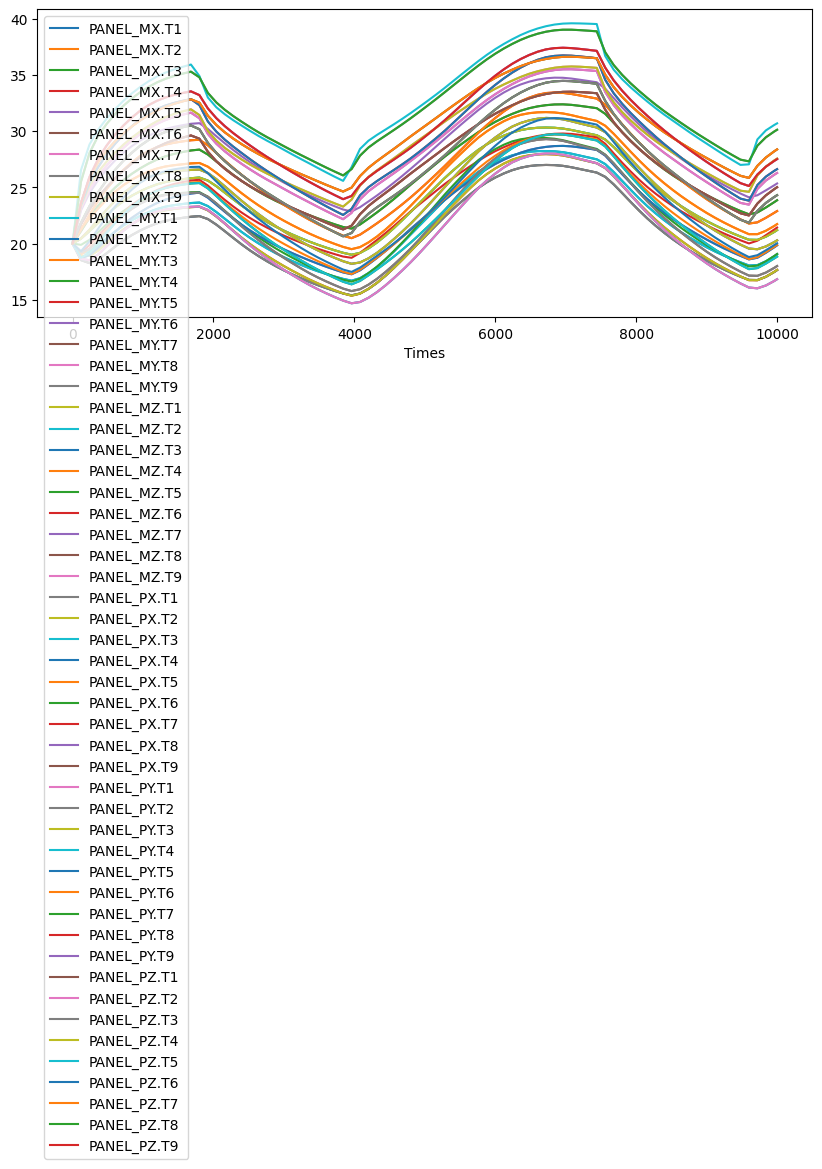

In [15]:
t_list = [s for s in df.columns if '.T' in s]
t_list = [s for s in t_list if not 'CHAMBER' in s]
t_list.remove('SPACE.T1')
df[['Times']+t_list].plot(x='Times', figsize=(10,4))

In [16]:
df_rad, df_cond = savefile.get_all_cond()

In [17]:
df_rad.head(10)

,Key,From,To,Is Rad,Value
37,C2A0.1,PANEL_MX.1,SPACE.1,True,1390.500000
38,C2A0.55,PANEL_MX.1,PANEL_MX.2,True,97.450325
39,C2A0.56,PANEL_MX.1,PANEL_MX.3,True,46.095684
40,C2A0.57,PANEL_MX.1,PANEL_MX.4,True,99.567024
41,C2A0.58,PANEL_MX.1,PANEL_MX.5,True,63.992245
42,C2A0.59,PANEL_MX.1,PANEL_MX.6,True,46.437336
43,C2A0.60,PANEL_MX.1,PANEL_MX.7,True,46.902950
44,C2A0.61,PANEL_MX.1,PANEL_MX.8,True,47.226685
45,C2A0.62,PANEL_MX.1,PANEL_MX.9,True,34.356583
46,C2A0.63,PANEL_MX.1,PANEL_MY.1,True,241.904816


In [18]:
df_cond.head(10)

,Key,From,To,Is Rad,Value
0,CHAMBER.1,CHAMBER.1,CHAMBER.2,False,0.031831
1,CHAMBER.2,CHAMBER.1,CHAMBER.3,False,0.031831
2,CHAMBER.3,CHAMBER.1,CHAMBER.4,False,0.201062
3,CHAMBER.4,CHAMBER.2,CHAMBER.3,False,0.031831
4,CHAMBER.5,CHAMBER.2,CHAMBER.5,False,0.201062
5,CHAMBER.6,CHAMBER.3,CHAMBER.6,False,0.201062
6,CHAMBER.7,CHAMBER.4,CHAMBER.5,False,0.031831
7,CHAMBER.8,CHAMBER.4,CHAMBER.6,False,0.031831
8,CHAMBER.9,CHAMBER.4,CHAMBER.7,False,0.201062
9,CHAMBER.10,CHAMBER.5,CHAMBER.6,False,0.031831


In [19]:
df_rad_matrix, df_cond_matrix = savefile.get_cond_matrix()

In [20]:
df_rad_matrix

,CHAMBER.1,CHAMBER.2,CHAMBER.3,CHAMBER.4,CHAMBER.5,CHAMBER.6,CHAMBER.7,CHAMBER.8,CHAMBER.9,CHAMBER.100,...,PANEL_PZ.1,PANEL_PZ.2,PANEL_PZ.3,PANEL_PZ.4,PANEL_PZ.5,PANEL_PZ.6,PANEL_PZ.7,PANEL_PZ.8,PANEL_PZ.9,SPACE.1
CHAMBER.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHAMBER.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHAMBER.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHAMBER.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHAMBER.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PANEL_PZ.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.179821,73.326469,90.481720,62.211483,90.467545,0.000000,48.957333,71.157051,100.315842,1490.882935
PANEL_PZ.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.991177,53.622993,34.127220,103.259911,70.784416,48.957333,0.000000,107.085434,40.888931,1515.464966
PANEL_PZ.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.971039,55.607765,51.018398,87.197166,79.287270,71.157051,107.085434,0.000000,79.207573,1512.583496
PANEL_PZ.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.018940,39.882206,44.323414,52.391068,76.931244,100.315842,40.888931,79.207573,0.000000,1539.265015


In [21]:
df_cond_matrix

,CHAMBER.1,CHAMBER.2,CHAMBER.3,CHAMBER.4,CHAMBER.5,CHAMBER.6,CHAMBER.7,CHAMBER.8,CHAMBER.9,CHAMBER.100,...,PANEL_PZ.1,PANEL_PZ.2,PANEL_PZ.3,PANEL_PZ.4,PANEL_PZ.5,PANEL_PZ.6,PANEL_PZ.7,PANEL_PZ.8,PANEL_PZ.9,SPACE.1
CHAMBER.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHAMBER.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHAMBER.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHAMBER.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHAMBER.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PANEL_PZ.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.179821,73.326469,90.481720,62.211483,90.467545,0.000000,48.957333,71.157051,100.315842,1490.882935
PANEL_PZ.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.991177,53.622993,34.127220,103.259911,70.784416,48.957333,0.000000,107.085434,40.888931,1515.464966
PANEL_PZ.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.971039,55.607765,51.018398,87.197166,79.287270,71.157051,107.085434,0.000000,79.207573,1512.583496
PANEL_PZ.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.018940,39.882206,44.323414,52.391068,76.931244,100.315842,40.888931,79.207573,0.000000,1539.265015


In [22]:
df_capacity = savefile.get_heat_capacity()
df_capacity

,capacity
0,2199.115
1,2199.115
2,2199.115
3,2199.115
4,2199.115
...,...
71,18.207
72,18.207
73,18.207
74,18.207
